# Prepare raw data for curvecurator

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pubchempy as pcp
from Bio.ExPASy import cellosaurus
from drevalpy.datasets.curvecurator import _exec_curvecurator, postprocess

## Load Data

In [2]:
RAW_FILE_PATH = Path("raw/GDSC1_public_raw_data_24Jul22.csv")

In [3]:
raw_df = pd.read_csv(RAW_FILE_PATH)
raw_df

/tmp/ipykernel_1350670/510338040.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv(RAW_FILE_PATH)


,RESEARCH_PROJECT,BARCODE,SCAN_ID,DATE_CREATED,SCAN_DATE,CELL_ID,MASTER_CELL_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,SEEDING_DENSITY,DRUGSET_ID,ASSAY,DURATION,POSITION,TAG,DRUG_ID,CONC,INTENSITY
0,Sanger_GDSC1,100541,1765,2010-04-18T23:00:00Z,NaN,2415,365,924238,K5,SIDM00056,250.0,505_a_5,a,3.0,1,B,NaN,NaN,26022
1,Sanger_GDSC1,100541,1765,2010-04-18T23:00:00Z,NaN,2415,365,924238,K5,SIDM00056,250.0,505_a_5,a,3.0,2,B,NaN,NaN,20491
2,Sanger_GDSC1,100541,1765,2010-04-18T23:00:00Z,NaN,2415,365,924238,K5,SIDM00056,250.0,505_a_5,a,3.0,3,UN-USED,NaN,NaN,181946
3,Sanger_GDSC1,100541,1765,2010-04-18T23:00:00Z,NaN,2415,365,924238,K5,SIDM00056,250.0,505_a_5,a,3.0,4,UN-USED,NaN,NaN,213387
4,Sanger_GDSC1,100541,1765,2010-04-18T23:00:00Z,NaN,2415,365,924238,K5,SIDM00056,250.0,505_a_5,a,3.0,5,UN-USED,NaN,NaN,166452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5976178,MGH_GDSC1,026_144_00287710,96581,2014-08-24T23:00:00Z,NaN,3344,737,910706,BL-41,SIDM00985,NaN,26_a_7,s,NaN,380,UN-USED,NaN,NaN,688924
5976179,MGH_GDSC1,026_144_00287710,96581,2014-08-24T23:00:00Z,NaN,3344,737,910706,BL-41,SIDM00985,NaN,26_a_7,s,NaN,381,UN-USED,NaN,NaN,674334
5976180,MGH_GDSC1,026_144_00287710,96581,2014-08-24T23:00:00Z,NaN,3344,737,910706,BL-41,SIDM00985,NaN,26_a_7,s,NaN,382,UN-USED,NaN,NaN,664066
5976181,MGH_GDSC1,026_144_00287710,96581,2014-08-24T23:00:00Z,NaN,3344,737,910706,BL-41,SIDM00985,NaN,26_a_7,s,NaN,383,B,NaN,NaN,34663


In [4]:
drug_names = pd.read_csv("../meta/screened_compounds_rel_8.4.csv")
drug_names["DRUG_NAME"] = drug_names.DRUG_NAME.apply(lambda x: x[:-1] if x[-1] == ' ' else x)  # remove trailing spaces for 'GSK-LSD1-2HCl', 'JAK1_8517'
drug_names.loc[drug_names.DRUG_NAME == 'torin2', 'DRUG_NAME'] = 'Torin 2'                      # fix torin2 being present with two names
drug_names

,DRUG_ID,SCREENING_SITE,DRUG_NAME,SYNONYMS,TARGET,TARGET_PATHWAY
0,1,MGH,Erlotinib,"Tarceva, RG-1415, CP-358774, OSI-774, Ro-50823...",EGFR,EGFR signaling
1,3,MGH,Rapamycin,"AY-22989, Sirolimus, WY-090217, Torisel, Rapamune",MTORC1,PI3K/MTOR signaling
2,5,MGH,Sunitinib,"Sutent, Sunitinib Malate, SU-11248","PDGFR, KIT, VEGFR, FLT3, RET, CSF1R",RTK signaling
3,6,MGH,PHA-665752,"PHA665752, PHA 665752",MET,RTK signaling
4,9,MGH,MG-132,"LLL cpd, MG 132, MG132","Proteasome, CAPN1",Protein stability and degradation
...,...,...,...,...,...,...
616,2362,SANGER,THR-103,WIMM synthesis,Mutant RAS,PI3K/MTOR signaling
617,2438,SANGER,ascorbate (vitamin C),back-up solution from YWKim,anti-oxidant proteins,Other
618,2439,SANGER,glutathione,"G6013, sigma",anti-oxidant proteins,Other
619,2498,SANGER,alpha-lipoic acid,aLA,Metabolism,Metabolism


In [5]:
# Remove failed drugs from the dataset
def remove_failed_drugs(df):
    # Remove rows where TAG == 'UN-USED'
    failed_positions = df[df['TAG'] == 'UN-USED'][['SCAN_ID', 'POSITION']]
    df = df.merge(failed_positions, on=['SCAN_ID', 'POSITION'], how='outer', indicator=True)
    df = df[df['_merge'] == 'left_only'].drop(columns='_merge')
    return df

# Remove missing drugs (where DRUG_ID is NA)
def remove_missing_drugs(df):
    # Remove rows where DRUG_ID is NA
    na_libs = df[df['DRUG_ID'].isna() & df['TAG'].str.contains("^(L|R|A)\d+", regex=True)]
    df = df.merge(na_libs[['SCAN_ID', 'POSITION']], on=['SCAN_ID', 'POSITION'], how='outer', indicator=True)
    df = df[df['_merge'] == 'left_only'].drop(columns='_merge')
    return df

# Calculate the mean intensity for a given tag
def calc_tag_mean(df, tag_name, mean_col_name="tag_mean"):
    # Check if tag exists for all SCAN_IDs
    check_for_tag = df[['SCAN_ID']].drop_duplicates().merge(
        df[df['TAG'] == tag_name].groupby('SCAN_ID').size().reset_index(name='count'),
        on='SCAN_ID', how='left'
    )
    if check_for_tag['count'].isna().any():
        print(check_for_tag['count'])
        raise ValueError(f"calcTagMean: {tag_name} is not present for some or all of the SCAN_IDs.")
    
    # Calculate mean intensity for the tag
    tag_means = df[df['TAG'] == tag_name].groupby('SCAN_ID')['INTENSITY'].mean().reset_index(name=mean_col_name)
    
    if tag_means[mean_col_name].isna().any():
        raise ValueError(f"calcTagMean: {tag_name} has a mean of NaN for some or all of the SCAN_IDs.")
    
    return tag_means

# Normalize the dataset with respect to controls
def normalize_data(df, trim=True, neg_control='NC-0', pos_control='B'):
    nc1 = calc_tag_mean(df, neg_control, "NC")
    pc1 = calc_tag_mean(df, pos_control, "PC")
    
    # Filter and select relevant columns
    normalized_data = df[df['TAG'].str.contains(r"(A|L|R)\d+(-D\d+)?-(S|C)")].copy()
    
    normalized_data['lib_drug'] = normalized_data['TAG'].str.extract(r"((L|R)\d+)(-D\d+)?-(S|C)")[0]
    normalized_data['lib_drug'] = np.where(normalized_data['lib_drug'].str.startswith("A"), np.nan, normalized_data['lib_drug'])
    
    normalized_data['anchor'] = normalized_data['TAG'].str.extract(r"(A\d+)-(S|C)")[0]
    normalized_data['anchor'] = np.where(normalized_data['anchor'].str.startswith("(L|R)"), np.nan, normalized_data['anchor'])
    
    normalized_data['dose'] = normalized_data['TAG'].str.extract(r"(A|L|R)\d+-?(D\d+)?-(S|C)")[1]
    normalized_data['treatment'] = normalized_data['TAG'].str.extract(r"((A|L|R)\d+)(-D\d+)?-(S|C)")[3]
    
    # Join library and anchor data
    libraries = normalized_data.loc[~normalized_data['lib_drug'].isna(), normalized_data.columns != 'anchor'].rename(columns={"DRUG_ID": "DRUG_ID_lib"}).copy()
    anchors = normalized_data.loc[~normalized_data['anchor'].isna(), ~normalized_data.columns.isin(["lib_drug", "dose"])].rename(columns={"DRUG_ID": "DRUG_ID_anch", "CONC": "CONC_anch"})
    
    if not anchors.empty:
        print("fotze")
        normalized_data = pd.merge(libraries, anchors, how='outer')
    else:
        normalized_data = libraries
    
    # Merge controls
    normalized_data = normalized_data.merge(nc1, on="SCAN_ID", how='left').merge(pc1, on="SCAN_ID", how='left')
    
    # Normalize intensity
    normalized_data['normalized_intensity'] = (normalized_data['INTENSITY'] - normalized_data['PC']) / (normalized_data['NC'] - normalized_data['PC'])
    
    # Trim values to range [0, 1]
    if trim:
        normalized_data['normalized_intensity'] = normalized_data['normalized_intensity'].clip(lower=0, upper=1000)
    
    normalized_data['norm_neg_pos'] = neg_control + "+" + pos_control
    #normalized_data['time_stamp'] = datetime.now()
    
    return normalized_data

# Main normalization function
def main_normalizer(gdsc_dataset):
    return normalize_data(remove_missing_drugs(remove_failed_drugs(gdsc_dataset)))

# Add DMSO controls
def add_dmso(df):
    unique_pairs = df[['cell_line', 'drug']].drop_duplicates()
    new_rows = unique_pairs.assign(dose=0, response=1.0)
    final_dataset = pd.concat([df, new_rows], ignore_index=True)
    return final_dataset

# Map drug names
def drug_name_mapper(df, drug_df):
    drug_df = drug_df[['DRUG_ID', 'DRUG_NAME', 'SYNONYMS', 'SCREENING_SITE']]#.rename(columns={'DRUG_ID': 'drug'})
    df = df.merge(drug_df, left_on='DRUG_ID_lib', right_on='DRUG_ID', how='left')
    df['DRUG_NAME'] = df['DRUG_NAME'].fillna(df['DRUG_ID_lib'].astype(str))
    return df.drop(columns='DRUG_ID').rename(columns={'DRUG_ID_lib': 'DRUG_ID'})

# Prepare the dataset for curve curator
def transform_for_curvecurator(df, drug_names):
    # Filter library drugs
    df = df[df['lib_drug'].str.startswith('L')]
    
    # Select relevant columns and rename them
    df = df.copy()
    #df.columns = ['cell_line', 'drug', 'dose', 'response', 'SANGER_MODEL_ID', "CELL_ID", "MASTER_CELL_ID"]
    
    # Add DMSO controls
    #df = add_dmso(df)
    
    # Map drug names
    df = drug_name_mapper(df, drug_names)
    # Reorder and sort columns
    df = df.sort_values(by=['CELL_LINE_NAME', 'DRUG_ID', 'CONC'])
    
    return df



## Prepare data

In [6]:
raw_df_without_empty_wells = remove_failed_drugs(raw_df)
raw_df_without_empty_wells

,RESEARCH_PROJECT,BARCODE,SCAN_ID,DATE_CREATED,SCAN_DATE,CELL_ID,MASTER_CELL_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,SEEDING_DENSITY,DRUGSET_ID,ASSAY,DURATION,POSITION,TAG,DRUG_ID,CONC,INTENSITY
0,Sanger_GDSC1,100541,1765,2010-04-18T23:00:00Z,NaN,2415,365,924238,K5,SIDM00056,250.0,505_a_5,a,3.0,1,B,NaN,NaN,26022
1,Sanger_GDSC1,100541,1765,2010-04-18T23:00:00Z,NaN,2415,365,924238,K5,SIDM00056,250.0,505_a_5,a,3.0,2,B,NaN,NaN,20491
24,Sanger_GDSC1,100541,1765,2010-04-18T23:00:00Z,NaN,2415,365,924238,K5,SIDM00056,250.0,505_a_5,a,3.0,25,B,NaN,NaN,19639
25,Sanger_GDSC1,100541,1765,2010-04-18T23:00:00Z,NaN,2415,365,924238,K5,SIDM00056,250.0,505_a_5,a,3.0,26,B,NaN,NaN,21506
26,Sanger_GDSC1,100541,1765,2010-04-18T23:00:00Z,NaN,2415,365,924238,K5,SIDM00056,250.0,505_a_5,a,3.0,27,NC-0,NaN,NaN,170731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5976156,MGH_GDSC1,026_144_00287710,96581,2014-08-24T23:00:00Z,NaN,3344,737,910706,BL-41,SIDM00985,NaN,26_a_7,s,NaN,349,NC-0,NaN,NaN,706419
5976157,MGH_GDSC1,026_144_00287710,96581,2014-08-24T23:00:00Z,NaN,3344,737,910706,BL-41,SIDM00985,NaN,26_a_7,s,NaN,359,B,NaN,NaN,38682
5976158,MGH_GDSC1,026_144_00287710,96581,2014-08-24T23:00:00Z,NaN,3344,737,910706,BL-41,SIDM00985,NaN,26_a_7,s,NaN,360,B,NaN,NaN,36097
5976181,MGH_GDSC1,026_144_00287710,96581,2014-08-24T23:00:00Z,NaN,3344,737,910706,BL-41,SIDM00985,NaN,26_a_7,s,NaN,383,B,NaN,NaN,34663


In [7]:
raw_df_with_drugs_only = remove_missing_drugs(raw_df_without_empty_wells)
raw_df_with_drugs_only

/tmp/ipykernel_1350670/1735160531.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  na_libs = df[df['DRUG_ID'].isna() & df['TAG'].str.contains("^(L|R|A)\d+", regex=True)]


,RESEARCH_PROJECT,BARCODE,SCAN_ID,DATE_CREATED,SCAN_DATE,CELL_ID,MASTER_CELL_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,SEEDING_DENSITY,DRUGSET_ID,ASSAY,DURATION,POSITION,TAG,DRUG_ID,CONC,INTENSITY
0,Sanger_GDSC1,100541,1765,2010-04-18T23:00:00Z,NaN,2415,365,924238,K5,SIDM00056,250.0,505_a_5,a,3.0,1,B,NaN,NaN,26022
1,Sanger_GDSC1,100541,1765,2010-04-18T23:00:00Z,NaN,2415,365,924238,K5,SIDM00056,250.0,505_a_5,a,3.0,2,B,NaN,NaN,20491
2,Sanger_GDSC1,100541,1765,2010-04-18T23:00:00Z,NaN,2415,365,924238,K5,SIDM00056,250.0,505_a_5,a,3.0,25,B,NaN,NaN,19639
3,Sanger_GDSC1,100541,1765,2010-04-18T23:00:00Z,NaN,2415,365,924238,K5,SIDM00056,250.0,505_a_5,a,3.0,26,B,NaN,NaN,21506
4,Sanger_GDSC1,100541,1765,2010-04-18T23:00:00Z,NaN,2415,365,924238,K5,SIDM00056,250.0,505_a_5,a,3.0,27,NC-0,NaN,NaN,170731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4699770,MGH_GDSC1,026_144_00287710,96581,2014-08-24T23:00:00Z,NaN,3344,737,910706,BL-41,SIDM00985,NaN,26_a_7,s,NaN,349,NC-0,NaN,NaN,706419
4699771,MGH_GDSC1,026_144_00287710,96581,2014-08-24T23:00:00Z,NaN,3344,737,910706,BL-41,SIDM00985,NaN,26_a_7,s,NaN,359,B,NaN,NaN,38682
4699772,MGH_GDSC1,026_144_00287710,96581,2014-08-24T23:00:00Z,NaN,3344,737,910706,BL-41,SIDM00985,NaN,26_a_7,s,NaN,360,B,NaN,NaN,36097
4699773,MGH_GDSC1,026_144_00287710,96581,2014-08-24T23:00:00Z,NaN,3344,737,910706,BL-41,SIDM00985,NaN,26_a_7,s,NaN,383,B,NaN,NaN,34663


In [8]:
normalized_df = normalize_data(raw_df_with_drugs_only)
normalized_df

/tmp/ipykernel_1350670/1735160531.py:42: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  normalized_data = df[df['TAG'].str.contains(r"(A|L|R)\d+(-D\d+)?-(S|C)")].copy()


,RESEARCH_PROJECT,BARCODE,SCAN_ID,DATE_CREATED,SCAN_DATE,CELL_ID,MASTER_CELL_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,...,DRUG_ID_lib,CONC,INTENSITY,lib_drug,dose,treatment,NC,PC,normalized_intensity,norm_neg_pos
0,Sanger_GDSC1,100541,1765,2010-04-18T23:00:00Z,NaN,2415,365,924238,K5,SIDM00056,...,1007.0,0.012500,47351,L1,D1,S,148522.285714,24590.46875,0.183654,NC-0+B
1,Sanger_GDSC1,100541,1765,2010-04-18T23:00:00Z,NaN,2415,365,924238,K5,SIDM00056,...,1007.0,0.006250,37567,L1,D2,S,148522.285714,24590.46875,0.104707,NC-0+B
2,Sanger_GDSC1,100541,1765,2010-04-18T23:00:00Z,NaN,2415,365,924238,K5,SIDM00056,...,1007.0,0.003125,59623,L1,D3,S,148522.285714,24590.46875,0.282676,NC-0+B
3,Sanger_GDSC1,100541,1765,2010-04-18T23:00:00Z,NaN,2415,365,924238,K5,SIDM00056,...,1007.0,0.001563,64894,L1,D4,S,148522.285714,24590.46875,0.325207,NC-0+B
4,Sanger_GDSC1,100541,1765,2010-04-18T23:00:00Z,NaN,2415,365,924238,K5,SIDM00056,...,1007.0,0.000781,89824,L1,D5,S,148522.285714,24590.46875,0.526366,NC-0+B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3179336,MGH_GDSC1,026_144_00287710,96581,2014-08-24T23:00:00Z,NaN,3344,737,910706,BL-41,SIDM00985,...,449.0,0.320000,755650,L14,D5,S,694180.595238,37323.96875,1.093581,NC-0+B
3179337,MGH_GDSC1,026_144_00287710,96581,2014-08-24T23:00:00Z,NaN,3344,737,910706,BL-41,SIDM00985,...,449.0,0.160000,727575,L14,D6,S,694180.595238,37323.96875,1.050840,NC-0+B
3179338,MGH_GDSC1,026_144_00287710,96581,2014-08-24T23:00:00Z,NaN,3344,737,910706,BL-41,SIDM00985,...,449.0,0.080000,739768,L14,D7,S,694180.595238,37323.96875,1.069402,NC-0+B
3179339,MGH_GDSC1,026_144_00287710,96581,2014-08-24T23:00:00Z,NaN,3344,737,910706,BL-41,SIDM00985,...,449.0,0.040000,756071,L14,D8,S,694180.595238,37323.96875,1.094222,NC-0+B


In [9]:
normalized_df["DRUG_ID_lib"] = normalized_df["DRUG_ID_lib"].astype(int)

In [10]:
formatted_gdsc1 = transform_for_curvecurator(normalized_df, drug_names)
formatted_gdsc1

,RESEARCH_PROJECT,BARCODE,SCAN_ID,DATE_CREATED,SCAN_DATE,CELL_ID,MASTER_CELL_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,...,lib_drug,dose,treatment,NC,PC,normalized_intensity,norm_neg_pos,DRUG_NAME,SYNONYMS,SCREENING_SITE
401498,MGH_GDSC1,018_996_0005436,38508,2010-12-01T00:00:00Z,NaN,3399,1027,924100,22RV1,SIDM00499,...,L1,D9,S,523571.761905,6090.5625,0.810815,NC-0+B,Doxorubicin,"Doxil, Rubex, Adriamycin, Adriablastin, Doxoru...",MGH
401497,MGH_GDSC1,018_996_0005436,38508,2010-12-01T00:00:00Z,NaN,3399,1027,924100,22RV1,SIDM00499,...,L1,D8,S,523571.761905,6090.5625,0.986642,NC-0+B,Doxorubicin,"Doxil, Rubex, Adriamycin, Adriablastin, Doxoru...",MGH
401496,MGH_GDSC1,018_996_0005436,38508,2010-12-01T00:00:00Z,NaN,3399,1027,924100,22RV1,SIDM00499,...,L1,D7,S,523571.761905,6090.5625,0.528134,NC-0+B,Doxorubicin,"Doxil, Rubex, Adriamycin, Adriablastin, Doxoru...",MGH
401495,MGH_GDSC1,018_996_0005436,38508,2010-12-01T00:00:00Z,NaN,3399,1027,924100,22RV1,SIDM00499,...,L1,D6,S,523571.761905,6090.5625,0.401125,NC-0+B,Doxorubicin,"Doxil, Rubex, Adriamycin, Adriablastin, Doxoru...",MGH
401494,MGH_GDSC1,018_996_0005436,38508,2010-12-01T00:00:00Z,NaN,3399,1027,924100,22RV1,SIDM00499,...,L1,D5,S,523571.761905,6090.5625,0.257141,NC-0+B,Doxorubicin,"Doxil, Rubex, Adriamycin, Adriablastin, Doxoru...",MGH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594794,Sanger_GDSC1,117833,65215,2013-04-17T23:00:00Z,NaN,2498,1489,908450,no-11,SIDM00573,...,L37,D5,S,306958.625000,15128.7500,1.211213,NC-0+B,I-CBP112,NaN,SANGER
1594793,Sanger_GDSC1,117833,65215,2013-04-17T23:00:00Z,NaN,2498,1489,908450,no-11,SIDM00573,...,L37,D4,S,306958.625000,15128.7500,1.079692,NC-0+B,I-CBP112,NaN,SANGER
1594792,Sanger_GDSC1,117833,65215,2013-04-17T23:00:00Z,NaN,2498,1489,908450,no-11,SIDM00573,...,L37,D3,S,306958.625000,15128.7500,1.023474,NC-0+B,I-CBP112,NaN,SANGER
1594791,Sanger_GDSC1,117833,65215,2013-04-17T23:00:00Z,NaN,2498,1489,908450,no-11,SIDM00573,...,L37,D2,S,306958.625000,15128.7500,1.036944,NC-0+B,I-CBP112,NaN,SANGER


## Creating replicate information

In [11]:
formatted_gdsc1["rounddose"] = formatted_gdsc1["CONC"].round(10)
formatted_gdsc1['mindose'] = formatted_gdsc1.groupby(["CELL_LINE_NAME", "DRUG_NAME"], as_index=False)['rounddose'].transform(min)
formatted_gdsc1['maxdose'] = formatted_gdsc1.groupby(["CELL_LINE_NAME", "DRUG_NAME"], as_index=False)['rounddose'].transform(max)
formatted_gdsc1['repl'] = formatted_gdsc1.groupby(["CELL_LINE_NAME", "CELL_ID", "DRUG_NAME", "lib_drug","rounddose"]).cumcount()
formatted_gdsc1

/tmp/ipykernel_1350670/728125044.py:2: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  formatted_gdsc1['mindose'] = formatted_gdsc1.groupby(["CELL_LINE_NAME", "DRUG_NAME"], as_index=False)['rounddose'].transform(min)
/tmp/ipykernel_1350670/728125044.py:3: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  formatted_gdsc1['maxdose'] = formatted_gdsc1.groupby(["CELL_LINE_NAME", "DRUG_NAME"], as_index=False)['rounddose'].transform(max)


,RESEARCH_PROJECT,BARCODE,SCAN_ID,DATE_CREATED,SCAN_DATE,CELL_ID,MASTER_CELL_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,...,PC,normalized_intensity,norm_neg_pos,DRUG_NAME,SYNONYMS,SCREENING_SITE,rounddose,mindose,maxdose,repl
401498,MGH_GDSC1,018_996_0005436,38508,2010-12-01T00:00:00Z,NaN,3399,1027,924100,22RV1,SIDM00499,...,6090.5625,0.810815,NC-0+B,Doxorubicin,"Doxil, Rubex, Adriamycin, Adriablastin, Doxoru...",MGH,0.004000,0.004000,5.0,0
401497,MGH_GDSC1,018_996_0005436,38508,2010-12-01T00:00:00Z,NaN,3399,1027,924100,22RV1,SIDM00499,...,6090.5625,0.986642,NC-0+B,Doxorubicin,"Doxil, Rubex, Adriamycin, Adriablastin, Doxoru...",MGH,0.008000,0.004000,5.0,0
401496,MGH_GDSC1,018_996_0005436,38508,2010-12-01T00:00:00Z,NaN,3399,1027,924100,22RV1,SIDM00499,...,6090.5625,0.528134,NC-0+B,Doxorubicin,"Doxil, Rubex, Adriamycin, Adriablastin, Doxoru...",MGH,0.016000,0.004000,5.0,0
401495,MGH_GDSC1,018_996_0005436,38508,2010-12-01T00:00:00Z,NaN,3399,1027,924100,22RV1,SIDM00499,...,6090.5625,0.401125,NC-0+B,Doxorubicin,"Doxil, Rubex, Adriamycin, Adriablastin, Doxoru...",MGH,0.032000,0.004000,5.0,0
401494,MGH_GDSC1,018_996_0005436,38508,2010-12-01T00:00:00Z,NaN,3399,1027,924100,22RV1,SIDM00499,...,6090.5625,0.257141,NC-0+B,Doxorubicin,"Doxil, Rubex, Adriamycin, Adriablastin, Doxoru...",MGH,0.064000,0.004000,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594794,Sanger_GDSC1,117833,65215,2013-04-17T23:00:00Z,NaN,2498,1489,908450,no-11,SIDM00573,...,15128.7500,1.211213,NC-0+B,I-CBP112,NaN,SANGER,0.039062,0.039062,10.0,0
1594793,Sanger_GDSC1,117833,65215,2013-04-17T23:00:00Z,NaN,2498,1489,908450,no-11,SIDM00573,...,15128.7500,1.079692,NC-0+B,I-CBP112,NaN,SANGER,0.156250,0.039062,10.0,0
1594792,Sanger_GDSC1,117833,65215,2013-04-17T23:00:00Z,NaN,2498,1489,908450,no-11,SIDM00573,...,15128.7500,1.023474,NC-0+B,I-CBP112,NaN,SANGER,0.625000,0.039062,10.0,0
1594791,Sanger_GDSC1,117833,65215,2013-04-17T23:00:00Z,NaN,2498,1489,908450,no-11,SIDM00573,...,15128.7500,1.036944,NC-0+B,I-CBP112,NaN,SANGER,2.500000,0.039062,10.0,0


In [12]:
unique_celldrugcombos = formatted_gdsc1[["CELL_LINE_NAME", "CELL_ID", "DRUG_NAME", "lib_drug"]].drop_duplicates()
unique_celldrugcombos["drugcellrep"] = unique_celldrugcombos.groupby(["CELL_LINE_NAME", "DRUG_NAME"], as_index=True).cumcount().astype(str)
unique_celldrugcombos

,CELL_LINE_NAME,CELL_ID,DRUG_NAME,lib_drug,drugcellrep
401498,22RV1,3399,Doxorubicin,L1,0
396539,22RV1,3399,Etoposide,L11,0
401516,22RV1,3399,Gemcitabine,L3,0
401534,22RV1,3399,Mitomycin-C,L5,0
396557,22RV1,3399,Vinorelbine,L13,0
...,...,...,...,...,...
1594779,no-11,2498,Refametinib,L33,1
1594769,no-11,2498,Pictilisib,L26,1
1899519,no-11,2498,Pevonedistat,L42,0
1594714,no-11,2498,PFI-3,L10,0


In [13]:
formatted_gdsc1 = formatted_gdsc1.merge(unique_celldrugcombos, on=["CELL_LINE_NAME", "CELL_ID", "DRUG_NAME", "lib_drug"])

In [14]:
formatted_gdsc1['replicate'] = pd.factorize(formatted_gdsc1[["repl", "drugcellrep"]].apply(tuple, axis=1))[0]
formatted_gdsc1['replicate'] = formatted_gdsc1.groupby(["CELL_LINE_NAME", "DRUG_NAME"])["replicate"].transform(lambda x: pd.factorize(x)[0])
formatted_gdsc1['nreplicates'] = formatted_gdsc1.groupby(["CELL_LINE_NAME", "DRUG_NAME"])["replicate"].transform('max')

## Drugname to PubChem mapping

In [15]:
filtered_gdsc1_drugs = drug_names.merge(formatted_gdsc1[['DRUG_ID', 'DRUG_NAME']].drop_duplicates(), on=["DRUG_ID", "DRUG_NAME"], how='right').drop(columns=['DRUG_ID']).drop_duplicates().set_index("DRUG_NAME")

In [16]:
filtered_gdsc1_drugs.SYNONYMS.fillna('', inplace=True)

In [17]:
results = {}
chembls = {}
manual_review = {}
inchis = {}
i = 0
for brd, vals in filtered_gdsc1_drugs.iterrows():
    if i % 10 == 0:
        print(i, '/', len(filtered_gdsc1_drugs))
   
    compounds = pcp.get_compounds(identifier=brd, namespace="name")
    if len(compounds) == 0:
        if vals["SYNONYMS"]:
            syns = vals["SYNONYMS"].split(', ')
            syncompounds = []
            for syn in syns:
                syncompounds.extend(pcp.get_compounds(identifier=brd, namespace="name"))
            if len(syncompounds) > 0:
                manual_review[brd] = syncompounds
            else:
                manual_review[brd] = [compounds]
        else:
            manual_review[brd] = [compounds]
    else:
        results[brd] = compounds[0].cid
        #print(dir(compounds[0]))
        inchis = compounds[0].inchi
        chembl = None
        for syn in compounds[0].synonyms or []:
            if syn.startswith("CHEMBL"):
                chembl = syn
                break
        chembls[brd] = chembl
    i += 1

0 / 396
10 / 396
20 / 396
30 / 396
40 / 396
50 / 396
60 / 396
70 / 396
80 / 396
90 / 396
100 / 396
110 / 396
120 / 396
130 / 396
140 / 396
150 / 396
160 / 396
170 / 396
180 / 396
190 / 396
200 / 396
210 / 396
220 / 396
230 / 396
240 / 396
250 / 396
260 / 396
270 / 396
280 / 396
290 / 396
300 / 396
310 / 396
320 / 396
330 / 396
340 / 396
350 / 396
360 / 396
370 / 396
380 / 396
390 / 396


### Checking results

In [18]:
len(results), len(manual_review)

(304, 74)

In [19]:
manual_review |= {brd: cid for brd, cid in results.items() if cid is None}

In [20]:
manual_review['965-D2']='GDSC_965-D2'
manual_review['993-D2']='GDSC_993-D2'
manual_review['AZD7969']='AZD7969'
manual_review['BAY ACCi']='BAY ACCi'
manual_review['BAY AKT1']='BAY AKT1'
manual_review['BAY-HDAC11_1']='BAY-HDAC11_1'
manual_review['BAY-HDAC11_2']='BAY-HDAC11_2'
manual_review['BAY-HDAC11_4']='BAY-HDAC11_4'
manual_review['BAY-MPS-combo 2 (paclitaxel 1 uM)']='36314_baympscombo2'  # these are modified on purpose to distinguish them from just 'Paclitaxel'
manual_review['BAY-MPS-combo-1 (paclitaxel 5 uM)']='36314_baympscombo1'  # these are modified on purpose to distinguish them from just 'Paclitaxel'
manual_review['BAY-MPS1']='BAY-MPS1'
manual_review['Bleomycin (10 uM)']='5360373_10uM'  # these are modified on purpose to distinguish them from just 'Bleomycin'
manual_review['Bleomycin (50 uM)']='5360373_50uM'  # these are modified on purpose to distinguish them from just 'Bleomycin'
manual_review['Brivanib, BMS-540215']='11234052'
manual_review['CAP-232, TT-232, TLN-232']='6918265'
manual_review['CCT245467']='CCT245467'
manual_review['CRT0105446']='117918919'
manual_review['CRT0160829']='CRT0160829'
manual_review['Cetuximab'] = 'Cetuximab'
manual_review['Dyrk1b_0191']='Dyrk1b_0191'
manual_review['EphB4_9721']='EphB4_9721'

manual_review['FEN1_3940']='FEN1_3940'
manual_review['FGFR_0939']='FGFR_0939'
manual_review['FGFR_3831']='FGFR_3831'

manual_review['FS106']='FS106'
manual_review['FS112']='FS112'
manual_review['FY012']='FY012'
manual_review['FY026']='FY026'
manual_review['FY069']='FY069'
manual_review['Genentech Cpd 10']='Genentech Cpd 10'
manual_review['IAP_5620']='IAP_5620'
manual_review['IAP_7638']='IAP_7638'
manual_review['ICL1100013']='ICL1100013'
manual_review['IGFR_3801']='IGFR_3801'
manual_review['JAK1_3715']='JAK1_3715'
manual_review['JAK3_7406']='JAK3_7406'
manual_review['JNK-9L']='JNK-9L'

manual_review['KIN001-042']='KIN001-042'
manual_review['KIN001-236']='KIN001-236'
manual_review['KIN001-260']='KIN001-260'


manual_review['MCT1_6447']='MCT1_6447'
manual_review['MCT4_1422']='MCT4_1422'

manual_review['MPS-1-IN-1']='25195352'

manual_review['MetAP2 Inhibitor, A832234']='MetAP2 Inhibitor, A832234'
manual_review['N22899-6-C1']='N22899-6-C1'
manual_review['N23918-95-7']='N23918-95-7'
manual_review['N24798-49-A1']='N24798-49-A1'
manual_review['Nutlin-3a (-)'] = '11433190'

manual_review['PARP_0108']='PARP_0108'
manual_review['PARP_9482']='PARP_9482'
manual_review['PARP_9495']='PARP_9495'

manual_review['PI3Ka_4409']='PI3Ka_4409'
manual_review['PLK_6522']='PLK_6522'



manual_review['QL-VIII-58']= '58525121'  # via lincs with SMILES identity search
manual_review['QL-XII-61']= '71576693'  # via lincs with SMILES identity search

manual_review['RAF_9304']='RAF_9304'
manual_review['TANK_1366']='TANK_1366'

manual_review['THZ-2-102-1']='THZ-2-102-1'
manual_review['THZ-2-49']='THZ-2-49'
manual_review['TL-1-85']='TL-1-85'
manual_review['TL-2-105']='TL-2-105'

manual_review['TTK_3146']='TTK_3146'
manual_review['Venotoclax']='49846579'

manual_review['XMD15-27']='XMD15-27'

manual_review['ZL049']='ZL049'
manual_review['ZL109']='ZL109'

manual_review['eEF2K Inhibitor, A-484954']='14998470'

manual_review['rTRAIL']='rTRAIL'
manual_review['JW-7-52-1']='25200142'
manual_review['1205']='GDSC_1205'
manual_review['HG-6-71-01']='HG-6-71-01'
manual_review['THZ-1-87']='THZ-1-87'
manual_review['THZ-2-98-01']='THZ-2-98-01'

manual_review['XMD11-50']='46843906'  # via lincs with SMILES identity search

In [21]:
# convert integer CIDs to strings, and in case of multitreatment the list to a comma separated string
def sanitize(val):
    if isinstance(val, int):
        return str(val)
    if isinstance(val, list):
        return ','.join([str(i) for i in val])
    return val

cids = pd.Series(results | manual_review, name="CID").apply(sanitize).astype(str)
cids

Doxorubicin          31703
Etoposide            36462
Gemcitabine          60750
Mitomycin-C           5746
Vinorelbine        5311497
                  ...     
THZ-1-87          THZ-1-87
XMD11-50          46843906
THZ-2-98-01    THZ-2-98-01
HG-6-71-01      HG-6-71-01
1205             GDSC_1205
Name: CID, Length: 378, dtype: object

In [50]:
cids["ETP-45835"] = 71755761  # fix this manually as the 46937430 ID points to the 2HCl version

In [51]:
chembls = pd.Series(chembls, name="CHEMBL")
chembls

Doxorubicin      CHEMBL53463
Etoposide        CHEMBL44657
Gemcitabine        CHEMBL888
Mitomycin-C        CHEMBL105
Vinorelbine     CHEMBL553025
                   ...      
Bortezomib      CHEMBL325041
XMD8-85        CHEMBL1673039
Seliciclib       CHEMBL14762
Salubrinal      CHEMBL180127
Lapatinib          CHEMBL554
Name: CHEMBL, Length: 304, dtype: object

## Cell line name to Cellosaurus Mapping

In [23]:
# Download Cellosaurus data in OBO format
url = "ftp://ftp.expasy.org/databases/cellosaurus/cellosaurus.txt"
filename = "cellosaurus.txt"
urllib.request.urlretrieve(url, filename)

In [24]:
cl_mappings = {}
btos = {}
with open(filename) as handle:
    records = cellosaurus.parse(handle)
    for record in records:
        if 'Homo sapiens' in record['OX'][0]:
            if record["ID"] not in cl_mappings:
                cl_mappings[record["ID"]] = []
            cl_mappings[record["ID"]].append(record["AC"])
            syns = record["SY"].split("; ")
            for syn in syns:
                if syn == '':
                    continue
                if syn not in cl_mappings:
                    cl_mappings[syn] = []
                cl_mappings[syn].append(record["AC"])
            for a, b in record["DR"]:
                if a == 'BTO':
                    if record["AC"] not in btos:
                        btos[record["AC"]] = []
                    btos[record["AC"]].append(b)

In [25]:
ccls = formatted_gdsc1["CELL_LINE_NAME"].unique()
mappings = {}
manual_checks = {}
for ccl in ccls:
    cellosaurus_ids = cl_mappings.get(ccl, [])
    if len(cellosaurus_ids) == 1:
        mappings[ccl] = cellosaurus_ids[0]
    else:
        manual_checks[ccl] = cellosaurus_ids

In [26]:
print("CCLs:", len(ccls), "matches:", len(mappings), "ambiguous:", len(manual_checks))

CCLs: 970 matches: 937 ambiguous: 33


In [27]:
manual_checks

{'697': ['CVCL_0079', 'CVCL_8056'],
 'ES-2': ['CVCL_3509', 'CVCL_AX39', 'CVCL_C769'],
 'ES4': ['CVCL_1200', 'CVCL_C771'],
 'ES5': ['CVCL_1201', 'CVCL_C772'],
 'ES6': ['CVCL_1202', 'CVCL_C773'],
 'ES7': ['CVCL_1203', 'CVCL_C774'],
 'ES8': ['CVCL_1204', 'CVCL_C775'],
 'G-292-Clone-A141B1': [],
 'H4': ['CVCL_6C19', 'CVCL_1239', 'CVCL_HA56'],
 'H9': ['CVCL_1240', 'CVCL_9773'],
 'HARA': [],
 'HH': [],
 'Hep3B2-1-7': [],
 'Hs-633T': [],
 'K2': ['CVCL_C8AN', 'CVCL_C7JZ'],
 'K5': ['CVCL_1322', 'CVCL_C8B0'],
 'KG-1': ['CVCL_0374', 'CVCL_2971'],
 'KS-1': [],
 'M14': ['CVCL_1395', 'CVCL_8102', 'CVCL_U345'],
 'ML-1': [],
 'MS-1': [],
 'NB1': ['CVCL_1440', 'CVCL_8812'],
 'NB4': ['CVCL_0005', 'CVCL_8821'],
 'NOS-1': [],
 'NTERA-2-cl-D1': [],
 'OMC-1': [],
 'PC-3': ['CVCL_4011', 'CVCL_0035', 'CVCL_S982'],
 'PC-3_[JPC-3]': [],
 'RCM-1': [],
 'SAT': [],
 'TK': [],
 'TT': ['CVCL_3174', 'CVCL_1774'],
 'U-87-MG': ['CVCL_0022', 'CVCL_GP63']}

In [28]:
manual_checks["697"] = 'CVCL_0079'  # according to cellmodelpassports mapping file and matching GDSC link on cellosaurus
manual_checks["ES-2"] = 'CVCL_3509'  # this is ES-2, according to cellmodelpassports mapping file and matching GDSC link on cellosaurus
manual_checks["ES4"] = 'CVCL_1200'  # this is ES-4, according to matching GDSC link on cellosaurus
manual_checks["ES5"] = 'CVCL_1201'  # this is ES-5, according to matching GDSC link on cellosaurus
manual_checks["ES6"] = 'CVCL_1202'  # this is ES-6, according to matching GDSC link on cellosaurus
manual_checks["ES7"] = 'CVCL_1203'  # this is ES-7, according to matching GDSC link on cellosaurus
manual_checks["ES8"] = 'CVCL_1204'  # this is ES-8, according to matching GDSC link on cellosaurus
manual_checks["G-292-Clone-A141B1"] = 'CVCL_2909'  # this is G-292 clone A141B1 according to matching GDSC link on cellosaurus
manual_checks["H4"] = 'CVCL_1239'  # this is H-4, according to matching GDSC link on cellosaurus
manual_checks["H9"] = 'CVCL_1240'  # this is H-9, according to matching GDSC link on cellosaurus
manual_checks["HARA"] = 'CVCL_2914'  # this is HARA [Human squamous cell lung carcinoma], according to matching GDSC link on cellosaurus
manual_checks["HH"] = 'CVCL_1280'    # this is HH [Human Lymphoma], according to cellmodelpassports mapping file and matching GDSC link on cellosaurus
manual_checks["Hep3B2-1-7"] = 'CVCL_0326'    # this is Hep 3B2.1-7, according to matching GDSC link on cellosaurus
manual_checks["Hs-633T"] = 'CVCL_0832'    # this is Hs 633.T, according to matching GDSC link on cellosaurus

manual_checks["K2"] = 'CVCL_AT85'  # this is K2 [Human melanoma], according to matching GDSC link on cellosaurus
manual_checks["K5"] = 'CVCL_1322'  # this is K5, according to matching GDSC link on cellosaurus
manual_checks["KG-1"] = 'CVCL_0374'  # this is KG-1, according to matching GDSC link on cellosaurus
manual_checks["KS-1"] = 'CVCL_1343'  # this is KS-1 [Human glioblastoma], according to matching GDSC link on cellosaurus

manual_checks["M14"] = 'CVCL_1395'  # this is M14, according to matching GDSC link on cellosaurus
manual_checks["ML-1"] = 'CVCL_H525'  # this is ML-1 [Human thyroid carcinoma], according to matching GDSC link on cellosaurus
manual_checks["MS-1"] = 'CVCL_1429'  # this is MS-1 [Human lung carcinoma], according to matching GDSC link on cellosaurus
manual_checks["NB1"] = 'CVCL_1440'  # this is NB1, according to matching GDSC link on cellosaurus
manual_checks["NB4"] = 'CVCL_0005'  # this is NB4, according to matching GDSC link on cellosaurus
manual_checks["NOS-1"] = 'CVCL_1610'  # this is NOS-1 [Human osteosarcoma], according to matching GDSC link on cellosaurus
manual_checks["NTERA-2-cl-D1"] = 'CVCL_3407'  # this is NT2-D1, according to matching GDSC link on cellosaurus

manual_checks["OMC-1"] = 'CVCL_1623'  # this is OMC-1 [Human cervical carcinoma], according to matching GDSC link on cellosaurus
manual_checks["PC-3"] = 'CVCL_0035'  # this is PC-3, according to matching GDSC link on cellosaurus
manual_checks["PC-3_[JPC-3]"] = 'CVCL_S982'  # this is PC-3 [Human lung carcinoma], according to matching GDSC link on cellosaurus
manual_checks["RCM-1"] = 'CVCL_1648'  # this is RCM-1 [Human rectal adenocarcinoma], according to matching GDSC link on cellosaurus
manual_checks["SAT"] = 'CVCL_3160'  # this is SAT [Human HNSCC], according to matching GDSC link on cellosaurus
manual_checks["TK"] = 'CVCL_3216'  # this is TK [Human B-cell lymphoma], according to matching GDSC link on cellosaurus
manual_checks["TT"] = 'CVCL_1774'  # this is TT, according to matching GDSC link on cellosaurus
manual_checks["U-87-MG"] = 'CVCL_0022'  # this is U-87MG ATCC, according to matching GDSC link on cellosaurus



In [29]:
rev_mapping = {}
for key, val in (mappings | manual_checks).items():
    if val not in rev_mapping:
        rev_mapping[val] = []
    rev_mapping[val].append(key)

In [30]:
any([len(val) != 1 for val in rev_mapping.values()])

False

In [31]:
len(rev_mapping)

970

In [32]:
mappings |= manual_checks

In [33]:
celline_mappings = pd.DataFrame.from_dict(mappings, orient='index')
celline_mappings.columns = ['CVCL']
btos_df = pd.DataFrame({'BTO': btos.values()}, index=btos.keys())

In [34]:
btos_df

,BTO
CVCL_IP58,[BTO:0006002]
CVCL_IP59,[BTO:0006003]
CVCL_L211,[BTO:0005352]
CVCL_5948,[BTO:0002603]
CVCL_8030,[BTO:0002947]
...,...
CVCL_6746,[BTO:0003554]
CVCL_WY40,[BTO:0006281]
CVCL_5906,[BTO:0003992]
CVCL_0588,[BTO:0003136]


In [35]:
cvcl_to_bto = celline_mappings.merge(btos_df, left_on='CVCL', right_index=True, how='left')
cvcl_to_bto['BTO'] = cvcl_to_bto.BTO.transform(lambda x: '' if pd.isna(x) else x[0])
cvcl_to_bto

,CVCL,BTO
22RV1,CVCL_1045,BTO:0002999
23132-87,CVCL_1046,
42-MG-BA,CVCL_1798,
451Lu,CVCL_6357,BTO:0003710
5637,CVCL_0126,BTO:0003137
...,...,...
RCM-1,CVCL_1648,
SAT,CVCL_3160,
TK,CVCL_3216,
TT,CVCL_1774,BTO:0003074


## Bringing viability, drug, and cell line mappings together

In [52]:
full_df = formatted_gdsc1.merge(cids, left_on='DRUG_NAME', right_index=True).merge(cvcl_to_bto, left_on='CELL_LINE_NAME', right_index=True).merge(chembls, left_on="DRUG_NAME", right_index=True, how='left')
full_df

,RESEARCH_PROJECT,BARCODE,SCAN_ID,DATE_CREATED,SCAN_DATE,CELL_ID,MASTER_CELL_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,...,mindose,maxdose,repl,drugcellrep,replicate,nreplicates,CID,CVCL,BTO,CHEMBL
0,MGH_GDSC1,018_996_0005436,38508,2010-12-01T00:00:00Z,NaN,3399,1027,924100,22RV1,SIDM00499,...,0.004000,5.0,0,0,0,1,31703,CVCL_1045,BTO:0002999,CHEMBL53463
1,MGH_GDSC1,018_996_0005436,38508,2010-12-01T00:00:00Z,NaN,3399,1027,924100,22RV1,SIDM00499,...,0.004000,5.0,0,0,0,1,31703,CVCL_1045,BTO:0002999,CHEMBL53463
2,MGH_GDSC1,018_996_0005436,38508,2010-12-01T00:00:00Z,NaN,3399,1027,924100,22RV1,SIDM00499,...,0.004000,5.0,0,0,0,1,31703,CVCL_1045,BTO:0002999,CHEMBL53463
3,MGH_GDSC1,018_996_0005436,38508,2010-12-01T00:00:00Z,NaN,3399,1027,924100,22RV1,SIDM00499,...,0.004000,5.0,0,0,0,1,31703,CVCL_1045,BTO:0002999,CHEMBL53463
4,MGH_GDSC1,018_996_0005436,38508,2010-12-01T00:00:00Z,NaN,3399,1027,924100,22RV1,SIDM00499,...,0.004000,5.0,0,0,0,1,31703,CVCL_1045,BTO:0002999,CHEMBL53463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2045357,MGH_GDSC1,402_697_0006009,38780,2010-12-16T00:00:00Z,NaN,3369,208,924241,NCI-H250,SIDM00721,...,0.019531,5.0,0,0,0,0,7251185,CVCL_1554,,CHEMBL465158
2045358,MGH_GDSC1,402_697_0006009,38780,2010-12-16T00:00:00Z,NaN,3369,208,924241,NCI-H250,SIDM00721,...,0.019531,5.0,0,0,0,0,7251185,CVCL_1554,,CHEMBL465158
2045359,MGH_GDSC1,402_697_0006009,38780,2010-12-16T00:00:00Z,NaN,3369,208,924241,NCI-H250,SIDM00721,...,0.019531,5.0,0,0,0,0,7251185,CVCL_1554,,CHEMBL465158
2045360,MGH_GDSC1,402_697_0006009,38780,2010-12-16T00:00:00Z,NaN,3369,208,924241,NCI-H250,SIDM00721,...,0.019531,5.0,0,0,0,0,7251185,CVCL_1554,,CHEMBL465158


ensure Bleomycin is duplicated (because of having two additional entries (Bleomycin 50um) and (Bleomycin 10um))

In [54]:
full_df.query("DRUG_NAME.str.startswith('Bleo')").DRUG_NAME.unique()

array(['Bleomycin', 'Bleomycin (50 uM)', 'Bleomycin (10 uM)'],
      dtype=object)

ensure Paclitaxel is duplicated (because of having two additional entries (Bleomycin 50um) and (Bleomycin 10um))

In [55]:
full_df.query("DRUG_NAME.str.startswith('BAY-MPS-combo')").DRUG_NAME.unique()

array(['BAY-MPS-combo-1 (paclitaxel 5 uM)',
       'BAY-MPS-combo 2 (paclitaxel 1 uM)'], dtype=object)

In [56]:
len(full_df.DRUG_NAME.unique())

378

In [57]:
len(full_df.CID.unique())

378

ensure all cellline drug combinations start with only one maxdose

In [58]:
full_df.groupby(["CELL_LINE_NAME", "DRUG_NAME"])[["maxdose", "mindose"]].nunique().value_counts()

maxdose  mindose
1        1          316735
Name: count, dtype: int64

ensure there are no duplicates remaining that cause problems when pivoting the dataframe for curvecurator input creation

In [59]:
full_df[full_df[["DRUG_NAME", "CELL_LINE_NAME", "rounddose", "replicate"]].duplicated(keep=False)][["DRUG_NAME", "CELL_LINE_NAME", "rounddose", "replicate", "MASTER_CELL_ID", "DRUG_ID"]]

,DRUG_NAME,CELL_LINE_NAME,rounddose,replicate,MASTER_CELL_ID,DRUG_ID


rename columns for use in CurveCurator and save. Original dose is renamed to "lib_dose" to prevent duplication of column name.

In [60]:
full_df.rename(columns={"dose": "lib_dose", "rounddose": "dose", "normalized_intensity": "response", "CVCL": "sample", "CID": "drug"}, inplace=True)
full_df.to_csv("viabilities_processed.csv", index=None)

In [61]:
preprocess(input_file="viabilities_processed.csv", output_dir='curvecurator', dataset_name="GDSC1", cores=200)

# Prepare for DrEvalPy

## Run CurveCurator

In [ ]:
_exec_curvecurator(Path("curvecurator"))

In [2]:
postprocess("curvecurator", dataset_name="GDSC1")

## Combine curvecurator output with original measures from publication

In [9]:
# load the curvecurator output
viability_df = pd.read_csv("curvecurator/GDSC1.csv", converters={"cell_line_id": str, "drug_id": str})

# load the processed viabilities from 00_preprocess_raw_for_curvecurator.ipynb
mapping_df = pd.read_csv("viabilities_processed.csv", converters={"CELL_LINE_NAME": str, "DRUG_NAME": str, "sample": str, "drug": str})[["CELL_LINE_NAME", "DRUG_NAME", "sample", "drug"]].drop_duplicates()

# merge based on cell_line_id, drug_id to get drug name and cell line name back
viability_df = viability_df.merge(mapping_df, left_on=["cell_line_id", "drug_id"], right_on=["sample", "drug"])
viability_df["DRUG_NAME"] = viability_df["DRUG_NAME"].str.strip()
viability_df["CELL_LINE_NAME"] = viability_df["CELL_LINE_NAME"].str.strip()
viability_df

/tmp/ipykernel_2364247/3613527050.py:5: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  mapping_df = pd.read_csv("viabilities_processed.csv", converters={"CELL_LINE_NAME": str, "DRUG_NAME": str, "sample": str, "drug": str})[["CELL_LINE_NAME", "DRUG_NAME", "sample", "drug"]].drop_duplicates()


,Name,SignalQuality,pEC50_curvecurator,Slope,Front,Back,FoldChange,AUC_curvecurator,RMSE,R2,...,RelevanceScore,Regulation,cell_line_id,drug_id,EC50_curvecurator,IC50_curvecurator,CELL_LINE_NAME,DRUG_NAME,sample,drug
0,CVCL_0001|5280757,0.0,8.108073,1.605647,1.046587,0.291085,-0.597186,0.986014,0.026809,0.952501,...,1.184949,NaN,CVCL_0001,5280757,7.796996e-09,1.419270e-08,HEL,Bryostatin 1,CVCL_0001,5280757
1,CVCL_0002|5280757,0.0,8.409941,10.000000,1.029465,0.831231,-0.266425,1.003695,0.033921,0.786028,...,0.174740,not,CVCL_0002,5280757,3.890980e-09,NaN,HL-60,Bryostatin 1,CVCL_0002,5280757
2,CVCL_0004|5280757,0.0,8.548625,10.000000,0.994296,1.050375,0.070902,1.004815,0.018237,0.593067,...,-0.000000,not,CVCL_0004,5280757,2.827320e-09,NaN,K-562,Bryostatin 1,CVCL_0004,5280757
3,CVCL_0005|5280757,0.0,8.438999,10.000000,1.005756,0.473905,-1.076716,0.930203,0.067179,0.884457,...,1.483146,down,CVCL_0005,5280757,3.639161e-09,4.894855e-09,NB4,Bryostatin 1,CVCL_0005,5280757
4,CVCL_0006|5280757,0.0,8.650062,10.000000,1.011980,0.960338,-0.058386,1.000118,0.021364,0.475456,...,-0.000000,not,CVCL_0006,5280757,2.238399e-09,NaN,THP-1,Bryostatin 1,CVCL_0006,5280757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316501,CVCL_1679|560326,0.0,3.245661,0.940205,1.146734,0.000100,-2.662959,0.717923,0.131186,0.878403,...,5.885312,down,CVCL_1679,560326,5.679878e-04,7.469557e-04,SBC-5,DMOG,CVCL_1679,560326
316502,CVCL_1705|8249,0.0,2.695512,0.603697,0.977624,0.370678,-0.707769,0.819998,0.230365,0.196853,...,0.170731,NaN,CVCL_1705,8249,2.015990e-03,1.755447e-02,SN12C,Phenformin,CVCL_1705,8249
316503,CVCL_1823|8249,0.0,4.361405,0.680181,0.984015,0.000100,-4.521686,0.275513,0.225811,0.548946,...,2.854092,down,CVCL_1823,8249,4.351059e-05,4.149321e-05,KARPAS-620,Phenformin,CVCL_1823,8249
316504,CVCL_1890|560326,0.0,3.844805,2.201153,1.024656,0.022761,-5.416412,0.423292,0.114006,0.931236,...,9.371340,down,CVCL_1890,560326,1.429537e-04,1.492399e-04,SU-DHL-16,DMOG,CVCL_1890,560326


In [10]:
# load the original data
orig_measures_df = pd.read_excel("raw/GDSC1_fitted_dose_response_24Jul22.xlsx", converters={"CELL_LINE_NAME": str, "DRUG_NAME": str, "LN_IC50": float, "AUC": float})
orig_measures_df["IC50"] = np.exp(orig_measures_df["LN_IC50"]) / 1e6  # original one is in µM, but we need it in M. 
orig_measures_df["DRUG_NAME"] = orig_measures_df["DRUG_NAME"].str.strip()
orig_measures_df["CELL_LINE_NAME"] = orig_measures_df["CELL_LINE_NAME"].str.strip()


# group based on CELL_LINE_NAME, DRUG_NAME, since the original data was sometimes fitted separately for some of the replicates
orig_measures_df_agg = orig_measures_df.groupby(["CELL_LINE_NAME", "DRUG_NAME"], as_index=False).agg({"LN_IC50": list, "AUC": list, "IC50": list})
orig_measures_df_agg

,CELL_LINE_NAME,DRUG_NAME,LN_IC50,AUC,IC50
0,22RV1,(5Z)-7-Oxozeaenol,[2.473594],[0.869413],[1.186501317148943e-05]
1,22RV1,5-Fluorouracil,[0.579534],[0.483063],[1.785206330735705e-06]
2,22RV1,965-D2,[3.072015],[0.912134],[2.1585353370766897e-05]
3,22RV1,993-D2,[5.010936],[0.979947],[0.0001500451126680445]
4,22RV1,A-83-01,[5.299894],[0.972256],[0.00020031557539838682]
...,...,...,...,...,...
315089,no-11,ZSTK474,[1.364746],[0.814901],[3.914728584640217e-06]
315090,no-11,Zibotentan,[6.212809],[0.980813],[0.0004991012594926354]
315091,no-11,"eEF2K Inhibitor, A-484954",[6.063043],[0.978596],[0.0004296809686728855]
315092,no-11,kb NB 142-70,[2.805599],[0.822334],[1.653697859008816e-05]


In [11]:
# check how many duplicates exist
orig_measures_df_agg["LN_IC50"].str.len().value_counts()

LN_IC50
1    297027
2     18067
Name: count, dtype: int64

<Axes: >

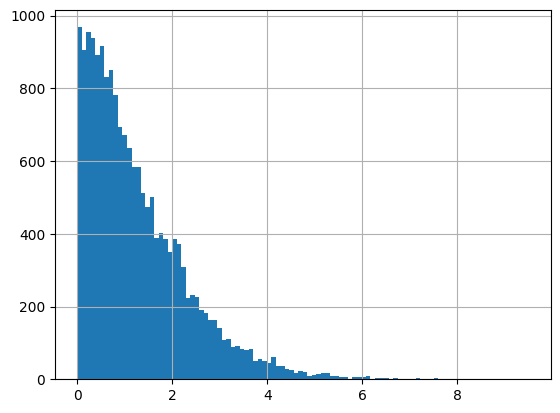

In [13]:
# check how well values agree with each other
orig_measures_df_agg.query("LN_IC50.str.len()>1")["LN_IC50"].apply(lambda x: abs(x[1]-x[0])).hist(bins=100)

<Axes: >

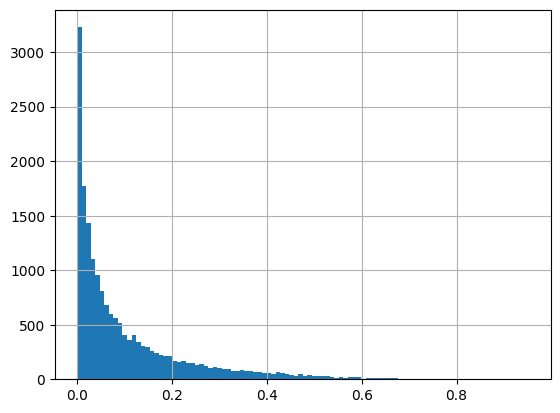

In [14]:
orig_measures_df_agg.query("AUC.str.len()>1")["AUC"].apply(lambda x: abs(x[1]-x[0])).hist(bins=100)

<Axes: >

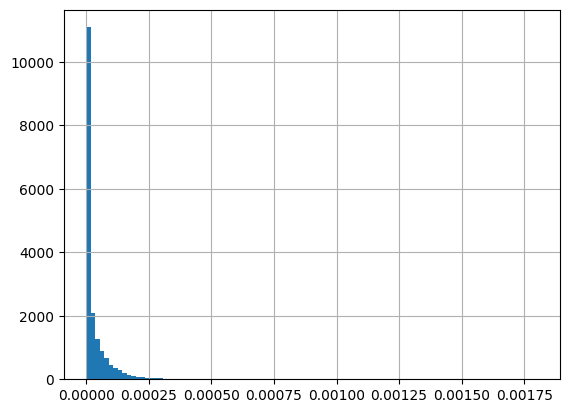

In [15]:
orig_measures_df_agg.query("IC50.str.len()>1")["IC50"].apply(lambda x: abs(x[1]-x[0])).hist(bins=100)

In [16]:
# aggregate mean
orig_measures_df = orig_measures_df.groupby(["CELL_LINE_NAME", "DRUG_NAME"], as_index=False).agg({"LN_IC50": 'mean', "AUC": 'mean', "IC50": 'mean'})
orig_measures_df

,CELL_LINE_NAME,DRUG_NAME,LN_IC50,AUC,IC50
0,22RV1,(5Z)-7-Oxozeaenol,2.473594,0.869413,0.000012
1,22RV1,5-Fluorouracil,0.579534,0.483063,0.000002
2,22RV1,965-D2,3.072015,0.912134,0.000022
3,22RV1,993-D2,5.010936,0.979947,0.000150
4,22RV1,A-83-01,5.299894,0.972256,0.000200
...,...,...,...,...,...
315089,no-11,ZSTK474,1.364746,0.814901,0.000004
315090,no-11,Zibotentan,6.212809,0.980813,0.000499
315091,no-11,"eEF2K Inhibitor, A-484954",6.063043,0.978596,0.000430
315092,no-11,kb NB 142-70,2.805599,0.822334,0.000017


In [17]:
# merge curvecurator and original fits
mapped_response_df = viability_df.merge(orig_measures_df, on=["DRUG_NAME", "CELL_LINE_NAME"], how='outer')
mapped_response_df

,Name,SignalQuality,pEC50_curvecurator,Slope,Front,Back,FoldChange,AUC_curvecurator,RMSE,R2,...,drug_id,EC50_curvecurator,IC50_curvecurator,CELL_LINE_NAME,DRUG_NAME,sample,drug,LN_IC50,AUC,IC50
0,CVCL_0001|5280757,0.0,8.108073,1.605647,1.046587,0.291085,-0.597186,0.986014,0.026809,0.952501,...,5280757,7.796996e-09,1.419270e-08,HEL,Bryostatin 1,CVCL_0001,5280757,-4.307089,0.948487,1.347271e-08
1,CVCL_0002|5280757,0.0,8.409941,10.000000,1.029465,0.831231,-0.266425,1.003695,0.033921,0.786028,...,5280757,3.890980e-09,NaN,HL-60,Bryostatin 1,CVCL_0002,5280757,-3.383405,0.968259,3.393172e-08
2,CVCL_0004|5280757,0.0,8.548625,10.000000,0.994296,1.050375,0.070902,1.004815,0.018237,0.593067,...,5280757,2.827320e-09,NaN,K-562,Bryostatin 1,CVCL_0004,5280757,-2.285847,0.983966,1.016879e-07
3,CVCL_0005|5280757,0.0,8.438999,10.000000,1.005756,0.473905,-1.076716,0.930203,0.067179,0.884457,...,5280757,3.639161e-09,4.894855e-09,NB4,Bryostatin 1,CVCL_0005,5280757,-4.940283,0.904285,7.152574e-09
4,CVCL_0006|5280757,0.0,8.650062,10.000000,1.011980,0.960338,-0.058386,1.000118,0.021364,0.475456,...,5280757,2.238399e-09,NaN,THP-1,Bryostatin 1,CVCL_0006,5280757,-2.800297,0.987445,6.079200e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,WSU-DLCL2,FY012,NaN,NaN,-0.011069,0.577376,9.889920e-07
316862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,WSU-DLCL2,HG-5-88-01,NaN,NaN,-0.947387,0.419535,3.877529e-07
316863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,WSU-DLCL2,IOX2,NaN,NaN,-6.229739,0.308971,1.969966e-09
316864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,YT,Belinostat,NaN,NaN,-2.577531,0.100658,7.596132e-08


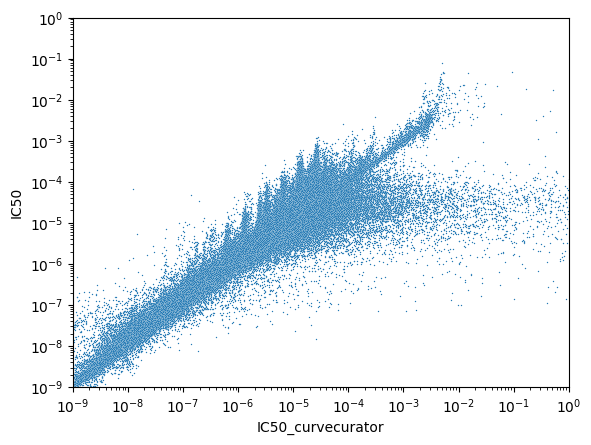

In [30]:
sns.scatterplot(mapped_response_df, x="IC50_curvecurator", y="IC50", s=1)
plt.xlim(1e-9,1e-0)
plt.ylim(1e-9,1e-0)

plt.xscale('log')
plt.yscale('log')

In [19]:
mapped_response_df.query("IC50_curvecurator<0.1")

,Name,SignalQuality,pEC50_curvecurator,Slope,Front,Back,FoldChange,AUC_curvecurator,RMSE,R2,...,drug_id,EC50_curvecurator,IC50_curvecurator,CELL_LINE_NAME,DRUG_NAME,sample,drug,LN_IC50,AUC,IC50
0,CVCL_0001|5280757,0.0,8.108073,1.605647,1.046587,0.291085,-0.597186,0.986014,0.026809,0.952501,...,5280757,7.796996e-09,1.419270e-08,HEL,Bryostatin 1,CVCL_0001,5280757,-4.307089,0.948487,1.347271e-08
3,CVCL_0005|5280757,0.0,8.438999,10.000000,1.005756,0.473905,-1.076716,0.930203,0.067179,0.884457,...,5280757,3.639161e-09,4.894855e-09,NB4,Bryostatin 1,CVCL_0005,5280757,-4.940283,0.904285,7.152574e-09
57,CVCL_0258|5280757,0.0,7.932904,0.973678,0.994555,0.103593,-0.666428,0.908255,0.012824,0.987911,...,5280757,1.167069e-08,1.464761e-08,EoL-1-cell,Bryostatin 1,CVCL_0258,5280757,-4.458350,0.915658,1.158146e-08
60,CVCL_0291|5280757,0.0,8.071121,10.000000,1.014154,0.000101,-0.613976,1.006113,0.037665,0.891939,...,5280757,8.489437e-09,8.513339e-09,HCT-116,Bryostatin 1,CVCL_0291,5280757,-3.874437,0.952793,2.076603e-08
62,CVCL_0312|5280757,0.0,8.074083,10.000000,0.978322,0.000100,-0.701638,0.970128,0.064571,0.740398,...,5280757,8.431742e-09,8.394619e-09,HOS,Bryostatin 1,CVCL_0312,5280757,-4.058017,0.942260,1.728326e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316501,CVCL_1679|560326,0.0,3.245661,0.940205,1.146734,0.000100,-2.662959,0.717923,0.131186,0.878403,...,560326,5.679878e-04,7.469557e-04,SBC-5,DMOG,CVCL_1679,560326,6.708085,0.698649,8.190008e-04
316502,CVCL_1705|8249,0.0,2.695512,0.603697,0.977624,0.370678,-0.707769,0.819998,0.230365,0.196853,...,8249,2.015990e-03,1.755447e-02,SN12C,Phenformin,CVCL_1705,8249,8.394486,0.860953,4.422613e-03
316503,CVCL_1823|8249,0.0,4.361405,0.680181,0.984015,0.000100,-4.521686,0.275513,0.225811,0.548946,...,8249,4.351059e-05,4.149321e-05,KARPAS-620,Phenformin,CVCL_1823,8249,3.869974,0.233076,4.794114e-05
316504,CVCL_1890|560326,0.0,3.844805,2.201153,1.024656,0.022761,-5.416412,0.423292,0.114006,0.931236,...,560326,1.429537e-04,1.492399e-04,SU-DHL-16,DMOG,CVCL_1890,560326,5.027467,0.411516,1.525461e-04


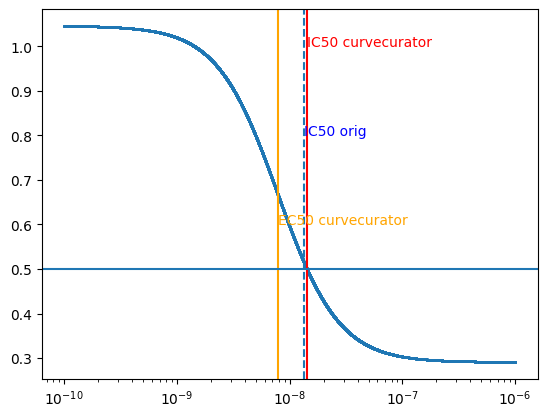

In [27]:
xvals = np.linspace(-10,-6, 10000)

index = 0
front = mapped_response_df.loc[index, "Front"]
back = mapped_response_df.loc[index, "Back"]
pec50 = mapped_response_df.loc[index, "pEC50_curvecurator"]
ec50 = mapped_response_df.loc[index, "EC50_curvecurator"]

slope = mapped_response_df.loc[index, "Slope"]
ic50 = mapped_response_df.loc[index, "IC50_curvecurator"]
origic50 = mapped_response_df.loc[index, "IC50"]


y = (front - back) / (1 + 10 ** (slope * (xvals + pec50))) + back
plt.scatter(10**xvals, 	y, s=1)


plt.axvline(origic50, linestyle='--')
plt.text(x=origic50, y=0.8, s='IC50 orig', color='blue')

plt.axvline(ic50, color="red")
plt.text(x=ic50, y=1.0, s='IC50 curvecurator', color='red')

plt.axvline(ec50, color="orange")
plt.text(x=ec50, y=0.6, s='EC50 curvecurator', color='orange')


plt.axhline(0.5)

plt.xscale('log')

In [31]:
mapped_response_df.to_csv("GDSC1_for_drevalpy.csv")